# Power Dissipation Index (PDI) Analysis

## Definitions 

PDI is an index that represents the destructive power of a storm combining together, intensity, duration, and frequency.

References: [Emanuel, 2005](ftp://texmex.mit.edu/pub/emanuel/PAPERS/NATURE03906.pdf) and [Emanuel, 2007](ftp://texmex.mit.edu/pub/emanuel/PAPERS/Factors.pdf)

In the references, Kerry Emanuel defines the index as:

$$PDI\equiv\int_0^{\tau}V^3_{max}dt~,$$

where $V_{max}$ is the maximum sustained wind speed, and $\tau$ is the lifetime of the storm event.



## The PDI Dataset

We're gonna use the PDI calculated by [National Oceanic & Atmospheric Administration (NOAA)](https://www.noaa.gov) which data is avaible at [Our World in Data](https://ourworldindata.org/grapher/cyclone-power-dissipation-index). It covers the North Atlantic, Caribbean and Gulf of Mexico storms.

The data has been smoothed through a five-year weighted average plotted at the center, in order to remove interannual variability. We're gonna o the same smooth with our climate dataset of Atlantic MDR.

In [508]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import scipy.stats as stats
from math import *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, HoltWintersResults
from statsmodels.tsa.stattools import adfuller
import datetime as dt
sns.set()
%matplotlib inline

In [2]:
raw_pdi = pd.read_csv('Datasets/cyclone-power-dissipation-index.csv')
raw_pdi

,Entity,Code,Year,"Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)"
0,North Atlantic,NaN,1951,2.7846
1,North Atlantic,NaN,1952,2.3445
2,North Atlantic,NaN,1953,2.2639
3,North Atlantic,NaN,1954,2.4730
4,North Atlantic,NaN,1955,2.4041
...,...,...,...,...
58,North Atlantic,NaN,2009,3.0860
59,North Atlantic,NaN,2010,3.2155
60,North Atlantic,NaN,2011,3.0646
61,North Atlantic,NaN,2012,2.4496


In [3]:
raw_pdi.dtypes

Entity                                                   object
Code                                                    float64
Year                                                      int64
Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)    float64
dtype: object

In [4]:
PDI = raw_pdi[['Year','Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)']].rename(
    columns={'Year': 'Year','Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)':'PDI'})
PDI.set_index('Year')

,PDI
Year,
1951,2.7846
1952,2.3445
1953,2.2639
1954,2.4730
1955,2.4041
...,...
2009,3.0860
2010,3.2155
2011,3.0646


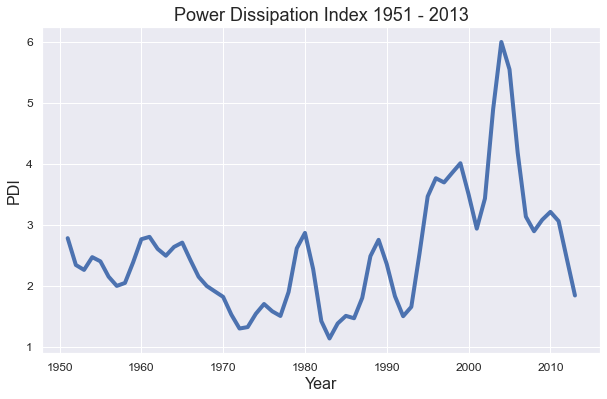

In [5]:
fig,ax = plt.subplots(figsize=(10,6))
plt.title("Power Dissipation Index 1951 - 2013",fontsize = 18)
plt.ylabel("PDI",fontsize = 16)
plt.xlabel("Year",fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.plot(PDI.Year,PDI.PDI,lw = 4);

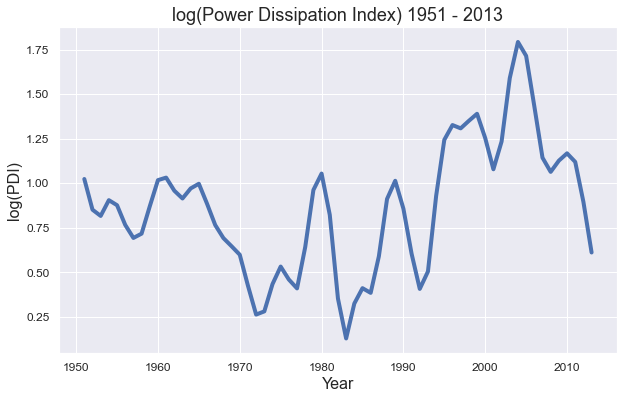

In [6]:
fig,ax = plt.subplots(figsize=(10,6))
plt.title("log(Power Dissipation Index) 1951 - 2013",fontsize = 18)
plt.ylabel("log(PDI)",fontsize = 16)
plt.xlabel("Year",fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.plot(PDI.Year,np.log(PDI.PDI),lw = 4);

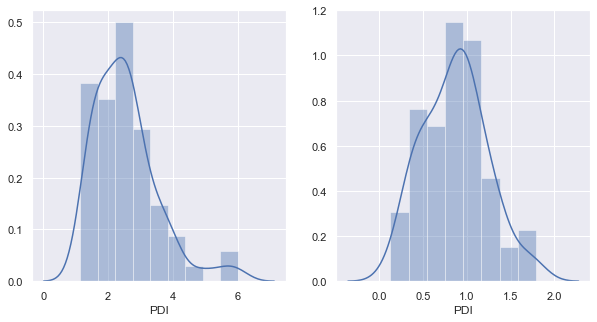

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
sns.distplot(PDI.PDI, ax=axs[0])
sns.distplot(np.log(PDI.PDI), ax=axs[1])

## Atlantic MDR Climate Data

Let's do the same smoothing operation in our "atlantic_mdr" dataset. We're gonna apply a 1–3–4–3–1 weighted average [Emanuel, 2007](ftp://texmex.mit.edu/pub/emanuel/PAPERS/Factors.pdf) on the data, to get out of interannual variability.

In [8]:
atlantic_mdr = pd.read_csv('./Datasets/atlantic_mdr.csv')

def smooth(col):
    n = len(col)
    new_col = np.zeros([n,1])
    w = np.array([[1,3,4,3,1]])
    
    for i in range(2,n-2):
        new_col[i] = w.dot(np.array(col[i-2:i+3]).reshape(-1,1))/12
    return new_col.ravel()


In [9]:
# atlantic_mdr = atlantic_mdr[(atlantic_mdr.Month>=8) & (atlantic_mdr.Month<=10)]
mdr_annual = atlantic_mdr.groupby('Year').agg({'sst':np.mean,
                                               'rhum':np.mean,
                                               'wspd':np.mean,
                                               'slp':np.mean,
                                               'vwnd':np.mean,
                                               'cldc':np.mean})


for col in mdr_annual.columns:
    mdr_annual.loc[:,col] = smooth(mdr_annual[col])
mdr_annual = mdr_annual.loc[1951:2013,:]
mdr_annual

,sst,rhum,wspd,slp,vwnd,cldc
Year,,,,,,
1951,27.897642,81.564450,6.039981,1011.181421,-0.690464,4.306995
1952,27.999758,81.676515,6.175088,1011.280791,-0.645274,4.329181
1953,28.013681,81.473732,6.205989,1011.249169,-0.608900,4.323822
1954,27.920470,81.129641,6.247379,1011.109891,-0.659149,4.335832
1955,27.801126,80.978218,6.311888,1011.019962,-0.745889,4.369884
...,...,...,...,...,...,...
2009,28.342664,80.619561,7.130693,1011.120257,-0.805964,4.712272
2010,28.309097,80.761136,7.130321,1011.076116,-0.857196,4.746834
2011,28.293840,80.914494,7.269408,1011.047399,-0.916701,4.792242


In [10]:
mdr_annual['PDI'] = np.array(PDI.PDI).reshape(-1,1)
mdr_annual

,sst,rhum,wspd,slp,vwnd,cldc,PDI
Year,,,,,,,
1951,27.897642,81.564450,6.039981,1011.181421,-0.690464,4.306995,2.7846
1952,27.999758,81.676515,6.175088,1011.280791,-0.645274,4.329181,2.3445
1953,28.013681,81.473732,6.205989,1011.249169,-0.608900,4.323822,2.2639
1954,27.920470,81.129641,6.247379,1011.109891,-0.659149,4.335832,2.4730
1955,27.801126,80.978218,6.311888,1011.019962,-0.745889,4.369884,2.4041
...,...,...,...,...,...,...,...
2009,28.342664,80.619561,7.130693,1011.120257,-0.805964,4.712272,3.0860
2010,28.309097,80.761136,7.130321,1011.076116,-0.857196,4.746834,3.2155
2011,28.293840,80.914494,7.269408,1011.047399,-0.916701,4.792242,3.0646


## Analysing Correlation

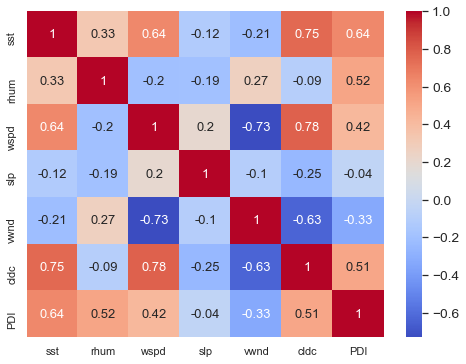

In [11]:

# corr = mdr_annual.corr()
# corr.style.background_gradient(cmap='coolwarm')
f,ax = plt.subplots(1,1,figsize=(8,6))
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.heatmap(mdr_annual.corr().round(2),
    cmap='coolwarm',annot = True,annot_kws={"size": 13});

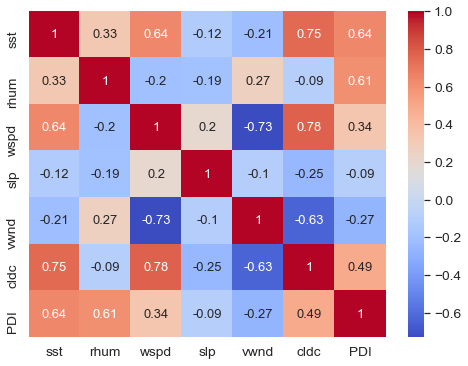

In [12]:
df = mdr_annual.copy()
df['PDI'] = np.log(df['PDI'])
# corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')

f,ax = plt.subplots(1,1,figsize=(8,6))
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.heatmap(df.corr().round(2),
    cmap='coolwarm',annot = True,annot_kws={"size": 13});

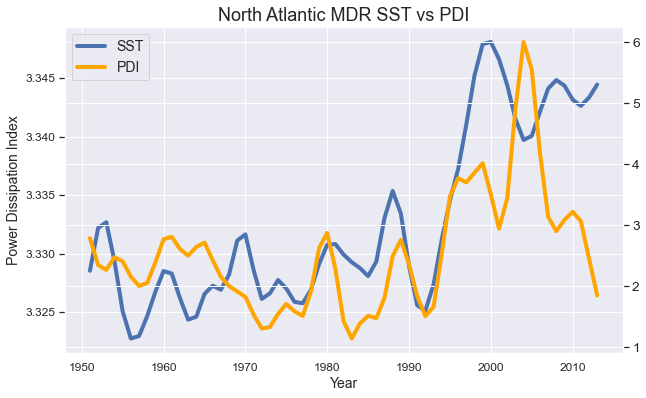

In [13]:
fig,ax = plt.subplots(figsize=(10,6))
plt.title("North Atlantic MDR SST vs PDI",fontsize = 18)

plt.xlabel("Year",fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

ax2 = ax.twinx()
ax.plot(np.log(mdr_annual.sst),lw = 4,label = "SST");
ax.set_ylabel("Sea Surface Temperature",fontsize=14)

ax2.plot(mdr_annual.PDI,lw=4,label="PDI",color = 'orange');
ax.set_ylabel("Power Dissipation Index",fontsize=14)


fig.legend(loc="upper left",fontsize=14,bbox_to_anchor=(0,1), bbox_transform=ax.transAxes);

In [14]:
# sns.scatterplot(x=X.sst, y=np.log(mdr_annual['PDI']))
# sns.scatterplot(x=X.sst, y=mdr_annual['PDI'])

## Simple Linear Model

In [15]:
X = mdr_annual.drop(["PDI"],axis=1) 
X = sm.add_constant(X)
# X.sst = np.log(X.sst)
Y = np.array(mdr_annual['PDI']).reshape(-1,1)
n=len(X)
X_train, X_test = X.iloc[:floor(0.8*n),:],X.iloc[n-floor(0.8*n):,:]
y_train, y_test = Y[:floor(0.8*n)],Y[n-floor(0.8*n):]

# Removido o preditor vwnd por ser ruido e wspd pela alta colinearidade com cldc.
# model = sm.OLS(y_train, X_train).fit()

model = sm.OLS(y_train, X_train.drop(columns=['vwnd','wspd'])).fit()
y_pred = model.predict(X_test.drop(columns=['vwnd','wspd'])) 
print(r2_score(y_test,y_pred))
print(model.summary())

0.6330190862913992
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     38.78
Date:                Sat, 29 Aug 2020   Prob (F-statistic):           4.84e-14
Time:                        13:48:38   Log-Likelihood:                -16.678
No. Observations:                  50   AIC:                             43.36
Df Residuals:                      45   BIC:                             52.92
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -803.3121    294.231 

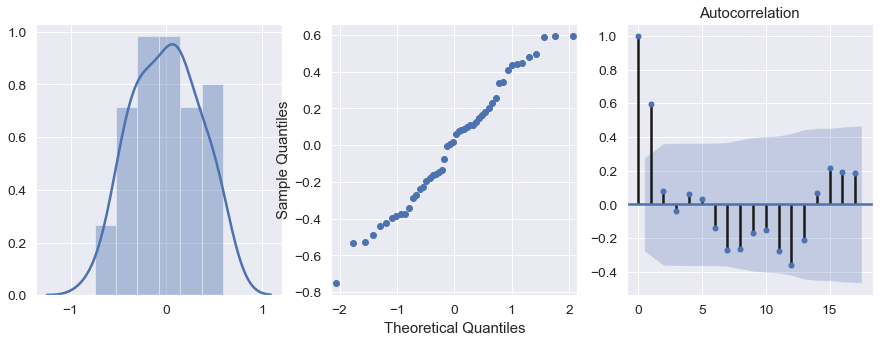

In [16]:
#residuos normais:
fig, axs = plt.subplots(1,3, figsize=[15,5])
sm.qqplot(model.resid, stats.norm, ax=axs[1])
plot_acf(model.resid, ax=axs[2])
sns.distplot(model.resid, ax=axs[0]) #residuos aproximadamente normais

In [17]:
# df = mdr_annual
# df.PDI = np.log(df.PDI)
# sns.pairplot(df) # o PDI fica mais proximo da gaussiana tirando o log; isso ajuda no ajuste da regressao

## Time series Analysis

In [556]:
tsPDI = pd.DataFrame(Y, index = [dt.datetime(x, 1, 1) for x in mdr_annual.index], columns=["PDI"])
tsPDI.head()

,PDI
1951-01-01,2.7846
1952-01-01,2.3445
1953-01-01,2.2639
1954-01-01,2.4730
1955-01-01,2.4041


In [1045]:
#Primeiro modelo: PDI como ARIMA(3,1,1)
mod = sm.tsa.ARIMA(tsPDI, order=(3, 1, 1))
modfit = mod.fit()
modfit.summary()

/home/gambitura/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/home/gambitura/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.PDI   No. Observations:                   62
Model:                 ARIMA(3, 1, 1)   Log Likelihood                  23.503
Method:                       css-mle   S.D. of innovations              0.155
Date:                Sun, 30 Aug 2020   AIC                            -35.007
Time:                        01:45:08   BIC                            -22.244
Sample:                    01-01-1952   HQIC                           -29.996
                         - 01-01-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0076      0.058     -0.130      0.896      -0.121       0.106
ar.L1.D.PDI     1.0309      0.123      8.364      0.000       0.789       1.273
ar.L2.D.PDI    -0.9534      0.132     -7.220      0.000      -1.212      -0.695
ar.L3.D.PDI     0.2464      0.124      1.986      0.047       0.003       0.490
ma.L1.D.PDI     0.9999      0.062     16.028      0.000       0.878       1.122
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4792           -1.0792j            1.1808           -0.1835
AR.2            0.4792           +1.0792j            1.1808            0.1835
AR.3            2.9108           -0.0000j            2.9108           -0.0000
MA.1           -1.0001           +0.0000j            1.0001            0.5000
-----------------------------------------------------------------------------
"""

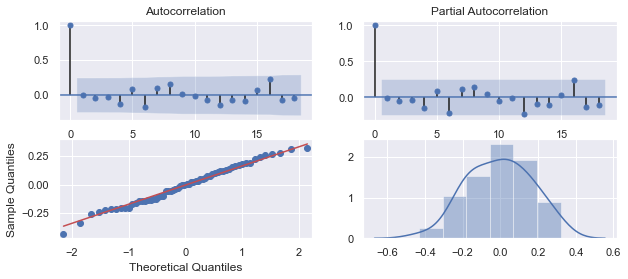

In [1099]:
fig, axs = plt.subplots(2,2, figsize = (10,4))
plot_acf(modfit.resid, ax = axs[0, 0])
plot_pacf(modfit.resid, ax = axs[0, 1])
sm.qqplot(modfit.resid, dist=stats.norm, line="s", ax = axs[1, 0])
sns.distplot(modfit.resid, ax = axs[1, 1])
plt.show()# modfit.plot_diagnostics()

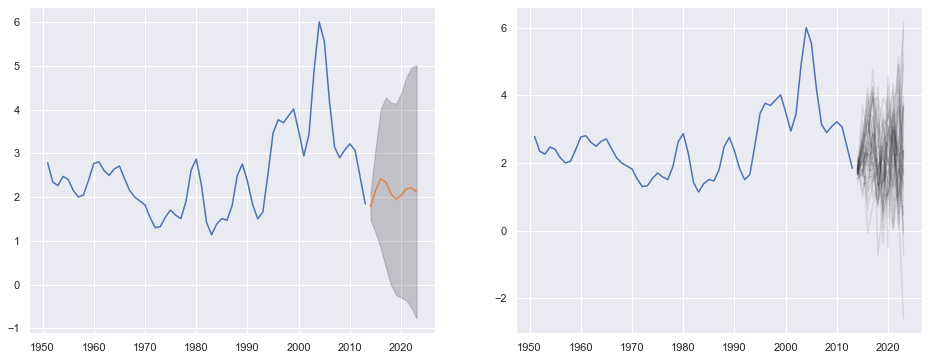

In [1052]:
fig, axs = plt.subplots(1,2, figsize = (16,6))

# With CI:
axs[0].plot(tsPDI['PDI'])
# plt.plot(tsPDI['PDI'], axs = axs[0])
step = 10
forecast = modfit.forecast(step)
x = pd.date_range(dt.datetime(2013,1,1), freq="A", periods=step)
axs[0].plot(x, forecast[0])
axs[0].fill_between(x, forecast[2][:,0], forecast[2][:,1], 
                    color='k', alpha=.2)
#simulating some cenarios:
sims = np.zeros((500, step))
for i in range(500):
    sims[i] = np.random.normal(forecast[0], forecast[1])

axs[1].plot(tsPDI['PDI'])
for i in range(40):
    axs[1].plot(x, sims[i], color = "k", alpha=.1) #teste de sanidade


plt.show()

In [674]:
tsLogPDI = tsPDI.apply(np.log)
#sm.tsa.stattools.adfuller(tsLogPDI['PDI']) ainda não é estacionaria a 5% de significancia

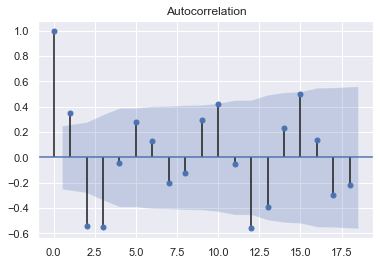

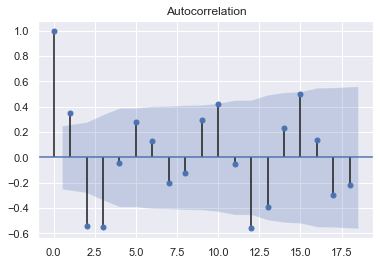

In [896]:
plot_acf(np.diff(tsLogPDI['PDI'], n = 2))

In [1053]:
#Primeiro modelo: log(PDI) como ARIMA(4,1,1)
mod2 = sm.tsa.ARIMA(tsLogPDI, order=(2, 1, 1))
modfit2 = mod2.fit()
modfit2.summary()

/home/gambitura/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/home/gambitura/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.PDI   No. Observations:                   62
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  66.779
Method:                       css-mle   S.D. of innovations              0.080
Date:                Sun, 30 Aug 2020   AIC                           -123.558
Time:                        01:46:07   BIC                           -112.922
Sample:                    01-01-1952   HQIC                          -119.382
                         - 01-01-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0051      0.020     -0.257      0.797      -0.044       0.034
ar.L1.D.PDI     0.7211      0.101      7.134      0.000       0.523       0.919
ar.L2.D.PDI    -0.6314      0.100     -6.300      0.000      -0.828      -0.435
ma.L1.D.PDI     0.7752      0.065     11.920      0.000       0.648       0.903
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5711           -1.1215j            1.2585           -0.1750
AR.2            0.5711           +1.1215j            1.2585            0.1750
MA.1           -1.2899           +0.0000j            1.2899            0.5000
-----------------------------------------------------------------------------
"""

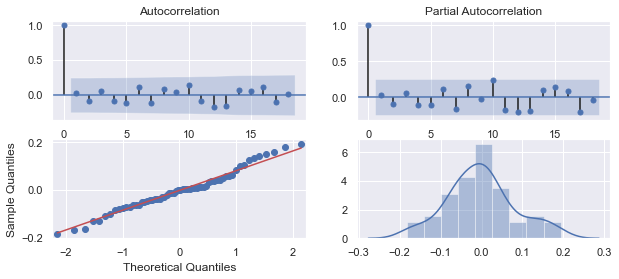

In [1054]:
fig, axs = plt.subplots(2,2, figsize = (10,4))
plot_acf(modfit2.resid, ax = axs[0, 0])
plot_pacf(modfit2.resid, ax = axs[0, 1])
sm.qqplot(modfit2.resid, dist=stats.norm, line="s", ax = axs[1, 0])
sns.distplot(modfit2.resid, ax = axs[1, 1])
plt.show()

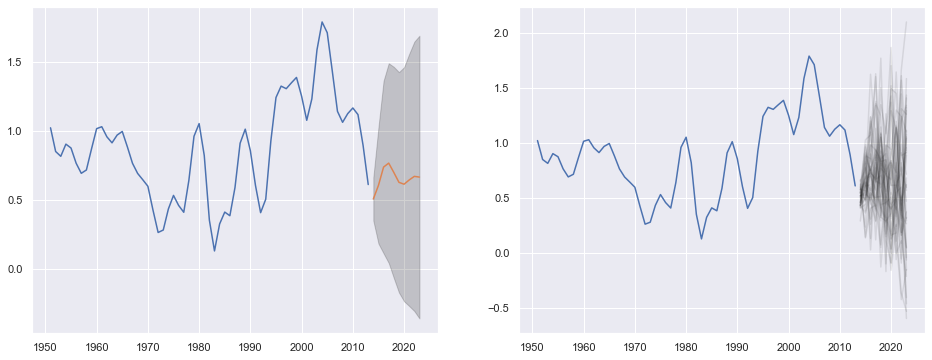

In [1055]:
fig, axs = plt.subplots(1,2, figsize = (16,6))

# With CI:
axs[0].plot(tsLogPDI['PDI'])
# plt.plot(tsPDI['PDI'], axs = axs[0])
step = 10
forecast = modfit2.forecast(step)
x = pd.date_range(dt.datetime(2013,1,1), freq="A", periods=step)
axs[0].plot(x, forecast[0])
axs[0].fill_between(x, forecast[2][:,0], forecast[2][:,1], 
                    color='k', alpha=.2)
#simulating some cenarios:
sims = np.zeros((500, step))
for i in range(500):
    sims[i] = np.random.normal(forecast[0], forecast[1])

axs[1].plot(tsLogPDI['PDI'])
for i in range(40):
    axs[1].plot(x, sims[i], color = "k", alpha=.1) #teste de sanidade


plt.show()

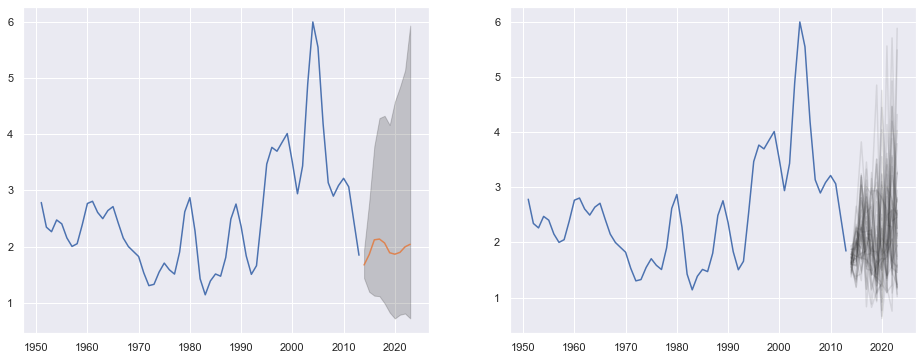

In [1137]:
fig, axs = plt.subplots(1,2, figsize = (16,6))

# With CI:
axs[0].plot(tsPDI['PDI'])
# plt.plot(tsPDI['PDI'], axs = axs[0])
step = 10
forecast = modfit2.forecast(step)
x = pd.date_range(dt.datetime(2013,1,1), freq="A", periods=step)

#simulating some cenarios:
sims = np.zeros((1000, step))
for i in range(1000):
    sims[i] = np.exp(np.random.normal(forecast[0], forecast[1]))
# computing some CIs:
CIs = np.zeros((step,3))
for i in range(step):
    CIs[i] = np.quantile(sims[:,i], [0.025, 0.5, 0.975])
axs[0].plot(x, CIs[:,1])
axs[0].fill_between(x, CIs[:,0], CIs[:,2], 
                    color='k', alpha=.2)

axs[1].plot(tsPDI['PDI'])
for i in range(40):
    axs[1].plot(x, sims[i], color = "k", alpha=.1) #teste de sanidade

plt.show()

In [1058]:
# plt.plot(np.log(np.diff(np.log(mdr_annual['PDI'])) + 1))
# sm.tsa.stattools.adfuller(np.log(np.diff(np.log(mdr_annual['PDI'])) + 1))
tsTr = np.log(np.diff(np.log(tsPDI['PDI']))+1)

In [1098]:
mod3 = sm.tsa.ARIMA(tsTr, order=(2,0,1))
modfit3 = mod3.fit()
modfit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   62
Model:                     ARMA(2, 1)   Log Likelihood                  59.420
Method:                       css-mle   S.D. of innovations              0.091
Date:                Sun, 30 Aug 2020   AIC                           -108.840
Time:                        01:51:11   BIC                            -98.204
Sample:                             0   HQIC                          -104.664
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0220      0.021     -1.029      0.304      -0.064       0.020
ar.L1.y        0.6979      0.110      6.346      0.000       0.482       0.913
ar.L2.y       -0.6057      0.108     -5.626      0.000      -0.817      -0.395
ma.L1.y        0.6821      0.095      7.144      0.000       0.495       0.869
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5761           -1.1485j            1.2849           -0.1760
AR.2            0.5761           +1.1485j            1.2849            0.1760
MA.1           -1.4660           +0.0000j            1.4660            0.5000
-----------------------------------------------------------------------------
"""

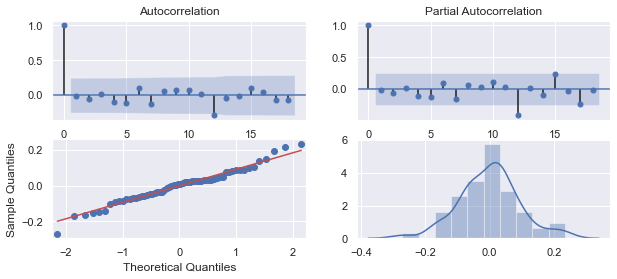

In [1100]:
fig, axs = plt.subplots(2,2, figsize = (10,4))
plot_acf(modfit3.resid, ax = axs[0, 0])
plot_pacf(modfit3.resid, ax = axs[0, 1])
sm.qqplot(modfit3.resid, dist=stats.norm, line="s", ax = axs[1, 0])
sns.distplot(modfit3.resid, ax = axs[1, 1])
plt.show()

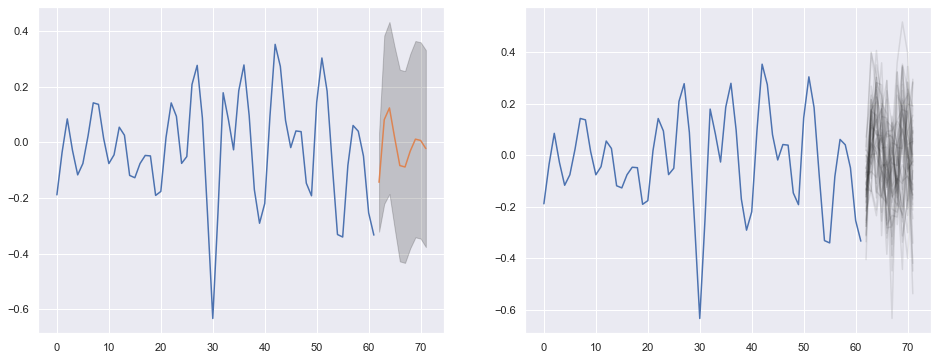

In [1105]:
fig, axs = plt.subplots(1,2, figsize = (16,6))

# With CI:
axs[0].plot(tsTr)
# plt.plot(tsPDI['PDI'], axs = axs[0])
step = 10
forecast = modfit3.forecast(step)
x = range(len(tsTr), len(tsTr) + step)
axs[0].plot(x, forecast[0])
axs[0].fill_between(x, forecast[2][:,0], forecast[2][:,1], 
                    color='k', alpha=.2)
#simulating some cenarios:
sims = np.zeros((500, step))
for i in range(500):
    sims[i] = np.random.normal(forecast[0], forecast[1])

axs[1].plot(tsTr)
for i in range(40):
    axs[1].plot(x, sims[i], color = "k", alpha=.1) #teste de sanidade

plt.show()

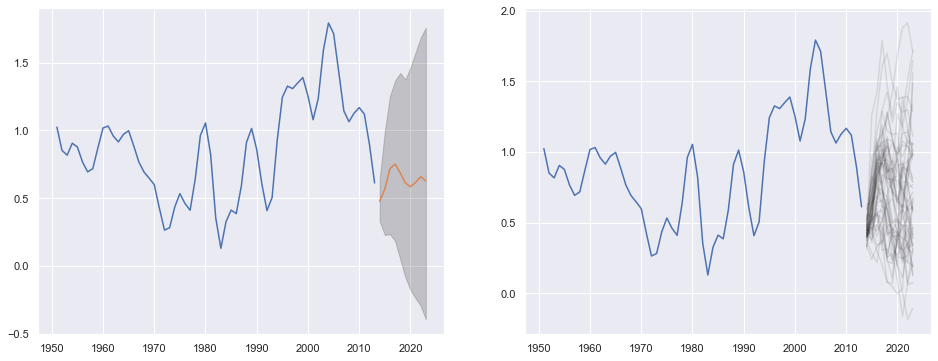

In [1152]:
fig, axs = plt.subplots(1,2, figsize = (16,6))

# With CI:
axs[0].plot(tsLogPDI['PDI'])
# plt.plot(tsPDI['PDI'], axs = axs[0])
step = 10
forecast = modfit3.forecast(step)
x = pd.date_range(dt.datetime(2013,1,1), freq="A", periods=step)

#simulating some cenarios:
dsims = np.zeros((1000, step))
for i in range(1000):
    dsims[i] = np.exp(np.random.normal(forecast[0], forecast[1])) - 1
last = tsLogPDI["PDI"].values[-1]
for i in range(len(dsims)):
    dsims[i] = last + np.cumsum(dsims[i])
# computing some CIs:
CIs = np.zeros((step,3))
for i in range(step):
    CIs[i] = np.quantile(dsims[:,i], [0.025, 0.5, 0.975])
axs[0].plot(x, CIs[:,1])
axs[0].fill_between(x, CIs[:,0], CIs[:,2], 
                    color='k', alpha=.2)

axs[1].plot(tsLogPDI['PDI'])
for i in range(50):
    axs[1].plot(x, dsims[i], color = "k", alpha=.1) #teste de sanidade

plt.show()

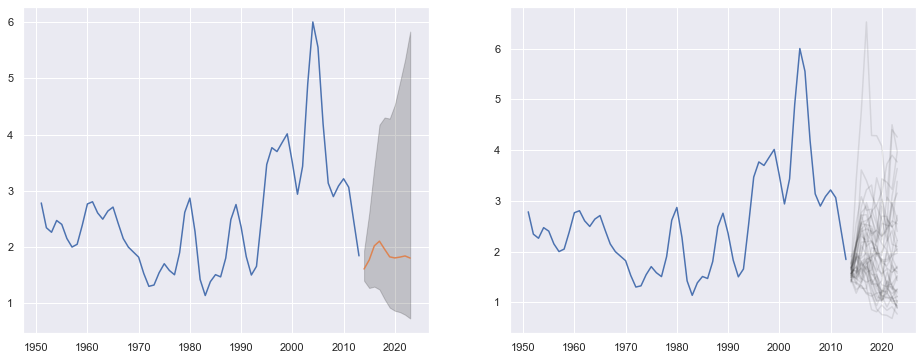

In [1150]:
fig, axs = plt.subplots(1,2, figsize = (16,6))

# With CI:
axs[0].plot(tsPDI['PDI'])
# plt.plot(tsPDI['PDI'], axs = axs[0])
step = 10
forecast = modfit3.forecast(step)
x = pd.date_range(dt.datetime(2013,1,1), freq="A", periods=step)

#simulating some cenarios:
dsims = np.zeros((1000, step))
for i in range(1000):
    dsims[i] = np.exp(np.random.normal(forecast[0], forecast[1])) - 1
last = tsLogPDI["PDI"].values[-1]
for i in range(len(dsims)):
    dsims[i] = np.exp(last + np.cumsum(dsims[i]))
# computing some CIs:
CIs = np.zeros((step,3))
for i in range(step):
    CIs[i] = np.quantile(dsims[:,i], [0.025, 0.5, 0.975])
axs[0].plot(x, CIs[:,1])
axs[0].fill_between(x, CIs[:,0], CIs[:,2], 
                    color='k', alpha=.2)

axs[1].plot(tsPDI['PDI'])
for i in range(40):
    axs[1].plot(x, dsims[i], color = "k", alpha=.1) #teste de sanidade

plt.show()

In [941]:
mod = ExponentialSmoothing(np.log(np.diff(np.log(mdr_annual['PDI']))+1)).fit(smoothing_level=0.5)
HoltWintersResults(mod, mod.params)

In [942]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 18, 8
# decomposition = sm.tsa.seasonal_decompose(np.log(np.diff(np.log(mdr_annual['PDI']))+1), 
#                                           model='additive', 
#                                           period=10)
# fig = decomposition.plot()
# plt.show()

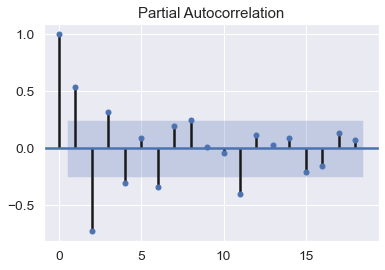

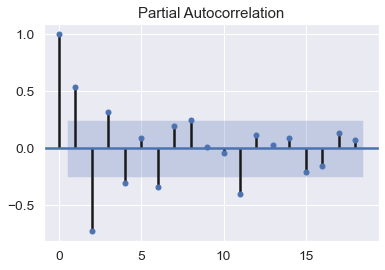

In [64]:
plot_pacf(np.log(np.diff(np.log(mdr_annual['PDI']))+1))

In [65]:
sm.tsa.stattools.adfuller(np.log(np.diff(np.log(mdr_annual['PDI']))+1))

(-4.290953889509212,
 0.0004605108859398415,
 5,
 56,
 {'1%': -3.552928203580539,
  '5%': -2.9147306250000002,
  '10%': -2.595137155612245},
 -79.19187325439549)

In [962]:
mod2 = sm.tsa.ARIMA(mdr_annual["PDI"], order=(3,1,1))
modfit2 = mod2.fit()

/home/gambitura/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/gambitura/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


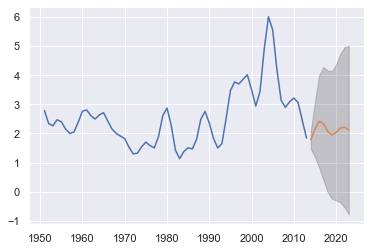

In [502]:
plt.plot(mdr_annual["PDI"])
dt = 10
plt.plot(range(2014, 2014+dt), modfit2.forecast(dt)[0])
plt.fill_between(range(2014, 2014+dt), 
                  modfit2.forecast(dt)[2][:,0], modfit2.forecast(dt)[2][:,1], color='k', alpha=.2)

In [432]:
modfit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.PDI   No. Observations:                   62
Model:                 ARIMA(3, 1, 1)   Log Likelihood                  23.503
Method:                       css-mle   S.D. of innovations              0.155
Date:                Sat, 29 Aug 2020   AIC                            -35.007
Time:                        16:59:49   BIC                            -22.244
Sample:                             1   HQIC                           -29.996
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0076      0.058     -0.130      0.896      -0.121       0.106
ar.L1.D.PDI     1.0309      0.123      8.364      0.000       0.789       1.273
ar.L2.D.PDI    -0.9534      0.132     -7.220      0.000      -1.212      -0.695
ar.L3.D.PDI     0.2464      0.124      1.986      0.047       0.003       0.490
ma.L1.D.PDI     0.9999      0.062     16.028      0.000       0.878       1.122
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4792           -1.0792j            1.1808           -0.1835
AR.2            0.4792           +1.0792j            1.1808            0.1835
AR.3            2.9108           -0.0000j            2.9108           -0.0000
MA.1           -1.0001           +0.0000j            1.0001            0.5000
-----------------------------------------------------------------------------
"""

In [392]:
modfit2.forecast(10)[2][:,1]

array([2.08942995, 3.11412657, 4.01137184, 4.27731098, 4.1637432 ,
       4.13537135, 4.3747808 , 4.73344543, 4.96341047, 5.01461916])

In [385]:
modfit2.forecast(10)

(array([1.78636693, 2.14687838, 2.41964235, 2.33773686, 2.07697568,
        1.94833758, 2.03903565, 2.18582237, 2.21387855, 2.12010218]),
 array([0.15462683, 0.49350304, 0.8121218 , 0.98959682, 1.06469687,
        1.11585406, 1.19172861, 1.29983157, 1.40284819, 1.47682151]),
 array([[ 1.48330392,  2.08942995],
        [ 1.1796302 ,  3.11412657],
        [ 0.82791286,  4.01137184],
        [ 0.39816274,  4.27731098],
        [-0.00979184,  4.1637432 ],
        [-0.2386962 ,  4.13537135],
        [-0.2967095 ,  4.3747808 ],
        [-0.36180069,  4.73344543],
        [-0.53565338,  4.96341047],
        [-0.77441479,  5.01461916]]))

In [500]:
x=20
pred2 = modfit2.get_prediction(start = x)
predCI2 = pred2.conf_int()
plt.plot(mdr_annual["PDI"])
plt.plot(range(x,x+len(pred2.predicted_mean)), pred2.predicted_mean, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(range(x,x+len(pred2.predicted_mean)),
               predCI2[:,0], predCI2[:,1], color='k', alpha=.2)
# ax = np.log(np.diff(np.log(mdr_annual['PDI']))+1)
plt.legend()

AttributeError: 'ARIMAResults' object has no attribute 'get_prediction'

In [ ]:
mod

In [176]:
mod = sm.tsa.arima.ARIMA(np.log(np.diff(np.log(mdr_annual['PDI']))+1), 
                         order=(4,1,0))
modfit = mod.fit()

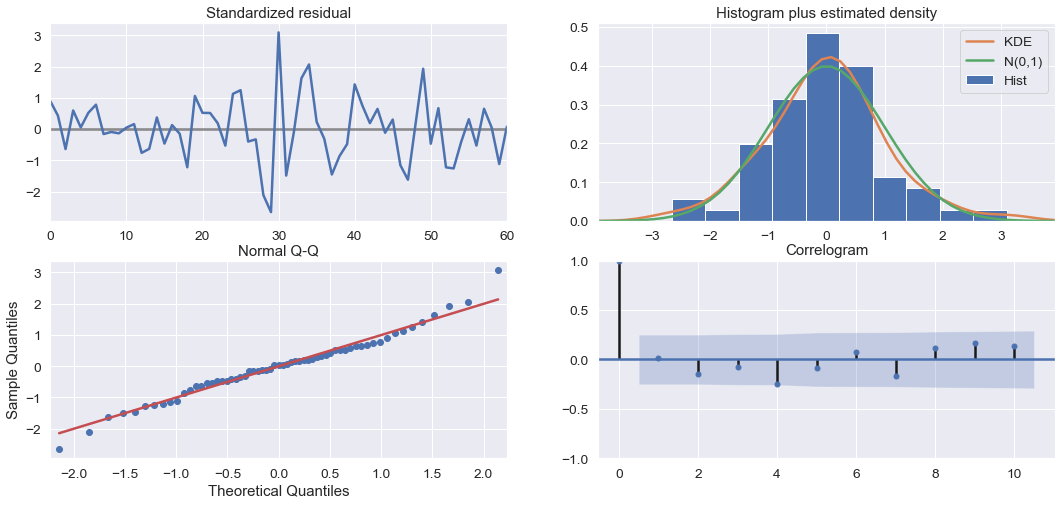

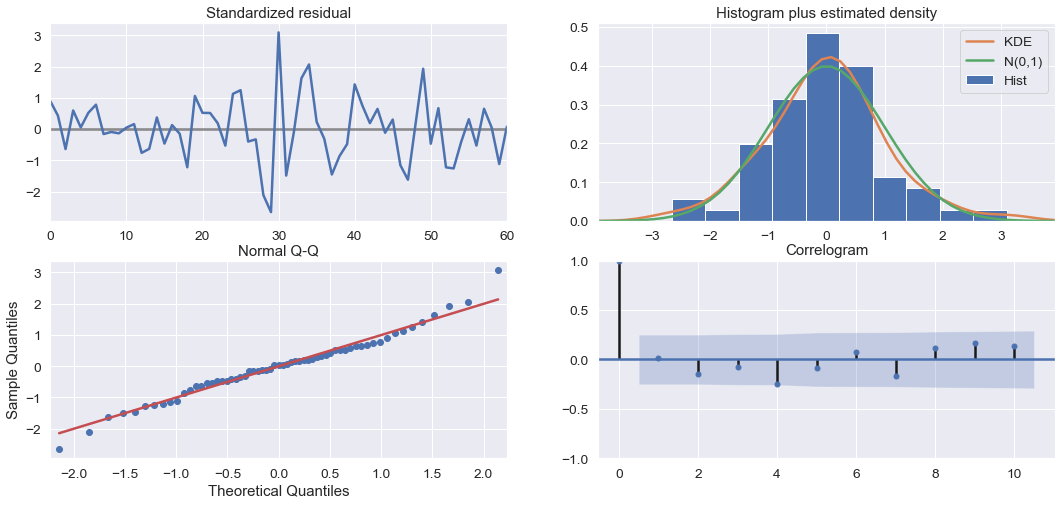

In [436]:
modfit.plot_diagnostics()

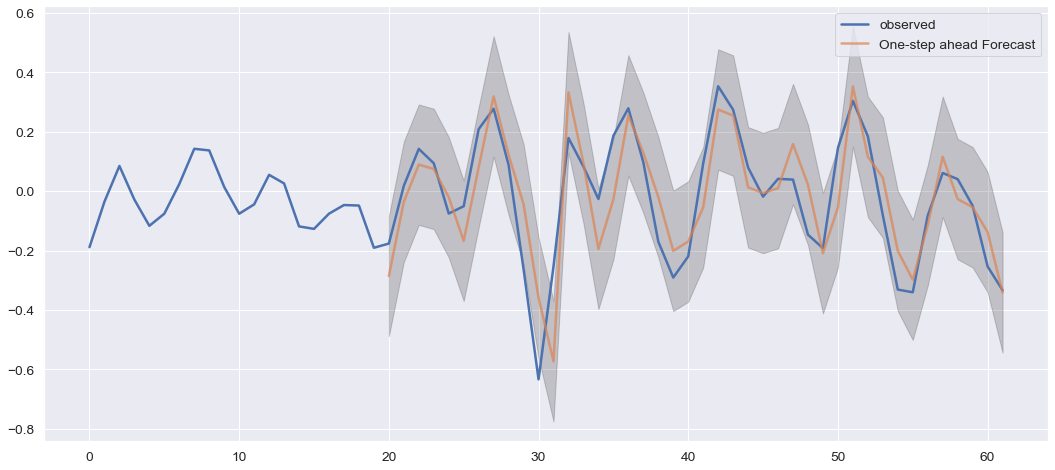

In [237]:
# plt.plot(np.log(np.diff(np.log(mdr_annual['PDI']))+1))
# plt.plot(modfit.summary)

# pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
# pred_ci = pred.conf_int()ax = y['2014':].plot(label='observed')
# pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)ax.set_xlabel('Date')
# ax.set_ylabel('Furniture Sales')
# plt.legend()plt.show()
x=20
pred = modfit.get_prediction(start = x)
predCI = pred.conf_int()
dg = pd.DataFrame(np.log(np.diff(np.log(mdr_annual['PDI']))+1), columns=["observed"])
ax = dg.plot(label = "observed")
plt.plot(range(x,x+len(pred.predicted_mean)),pred.predicted_mean, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(range(x,x+len(pred.predicted_mean)),
               predCI[:,0], predCI[:,1], color='k', alpha=.2)
# ax = np.log(np.diff(np.log(mdr_annual['PDI']))+1)
plt.legend()

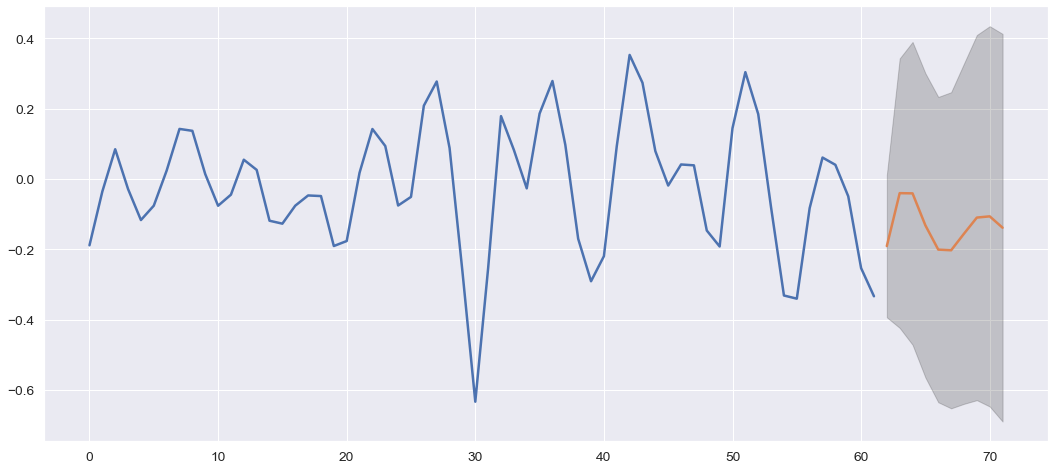

In [296]:
d = np.log(np.diff(np.log(mdr_annual['PDI']))+1)
plt.plot(d, label = "observed")
step_ahead = 10
forecast = modfit.get_forecast(step_ahead)
forecastCI = forecast.conf_int()
plt.plot(range(len(d), len(d) + step_ahead), forecast.predicted_mean)
plt.fill_between(range(len(d), len(d) + step_ahead),
               forecastCI[:,0], forecastCI[:,1], color='k', alpha=.2)
# forecast = modfit.get_forecast(15)
# forecast.conf_int()

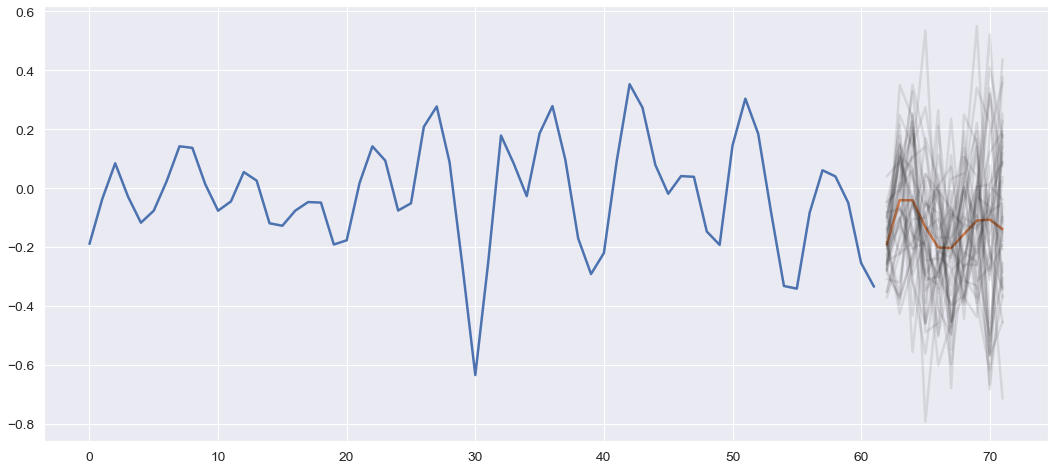

In [326]:
d = np.log(np.diff(np.log(mdr_annual['PDI']))+1)
plt.plot(d, label = "observed")
step_ahead = 10
forecast = modfit.get_forecast(step_ahead)
forecastCI = forecast.conf_int()
plt.plot(range(len(d), len(d) + step_ahead), forecast.predicted_mean)
for i in range(40):
    plt.plot(range(len(d), len(d) + step_ahead), 
             np.random.normal(forecast.predicted_mean, forecast.se_mean),
             color = "k", alpha=.1) #teste de sanidade

In [490]:
sims = np.zeros((500,10))
for i in range(500):
    sims[i] = np.exp(np.exp(np.random.normal(forecast.predicted_mean, forecast.se_mean)) - 1)
last = mdr_annual['PDI'].values[-1]
predsims = np.zeros((500,10))
for i in range(500):
    predsims[i] = last * sims[i].cumprod()

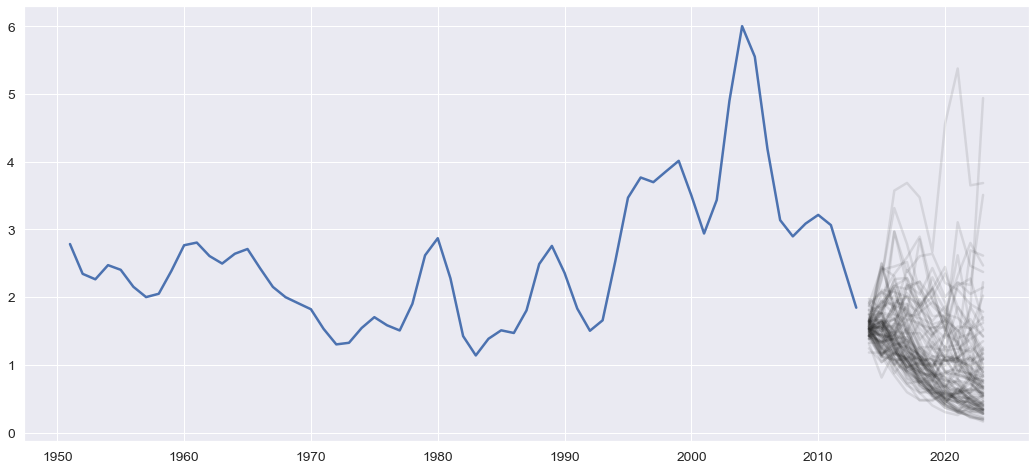

In [491]:
d = mdr_annual['PDI']
plt.plot(d, label = "observed")
step_ahead = 10
forecast = modfit.get_forecast(step_ahead)
# forecastCI = forecast.conf_int()
# plt.plot(range(len(d), len(d) + step_ahead), forecast.predicted_mean)
for i in range(100):
    plt.plot(range(2014, 2014 + step_ahead), 
             predsims[i],
             color = "k", alpha=.1) #teste de sanidade

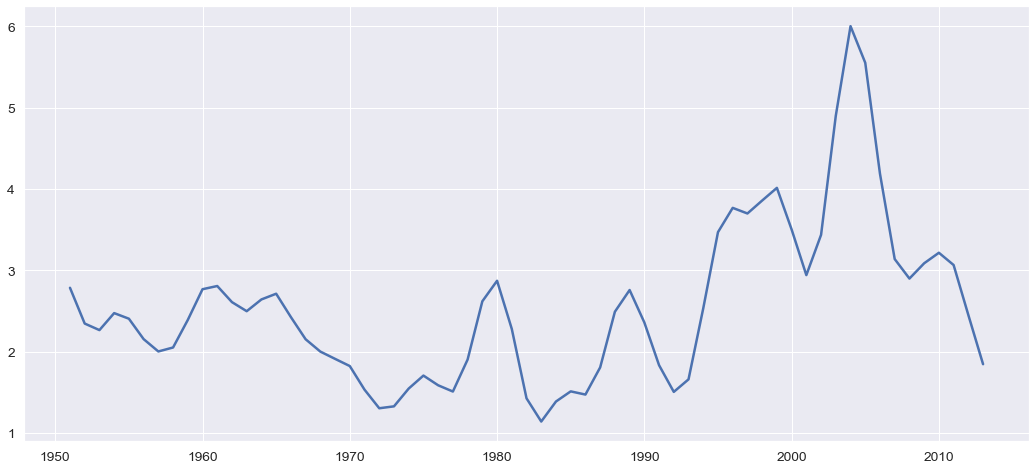

In [476]:
d = mdr_annual['PDI']
plt.plot(d, label = "observed")

In [465]:
last

1.8444

In [473]:
ç = sims[0]
ç.cumprod()

array([0.835755  , 0.82600095, 1.00208375, 1.12019996, 1.07462671,
       0.93010305, 0.99938746, 1.00463347, 1.10573486, 0.76881583])

In [449]:
np.exp(np.exp(np.random.normal(forecast.predicted_mean, forecast.se_mean)) - 1)

array([0.91319472, 0.89026157, 0.95750712, 0.84256564, 0.66690575,
       0.98509801, 0.98352075, 0.69810918, 0.84144779, 0.80426705])

In [290]:
ç = forecast.prediction_results

In [260]:
modfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   62
Model:                 ARIMA(4, 1, 0)   Log Likelihood                  50.771
Date:                Sat, 29 Aug 2020   AIC                            -91.542
Time:                        16:12:40   BIC                            -80.988
Sample:                             0   HQIC                           -87.406
                                 - 62                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6054      0.080      7.563      0.000       0.448       0.762
ar.L2         -1.0024      0.142     -7.043      0.000      -1.281      -0.723
ar.L3          0.2292      0.121      1.894      0.058      -0.008       0.466
ar.L4         -0.3416      0.122     -2.790      0.005      -0.582      -0.102
sigma2         0.0107      0.002      6.096      0.000       0.007       0.014
===================================================================================
Ljung-Box (Q):                       47.13   Jarque-Bera (JB):                 2.60
Prob(Q):                              0.20   Prob(JB):                         0.27
Heteroskedasticity (H):               2.22   Skew:                             0.18
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Count(?)

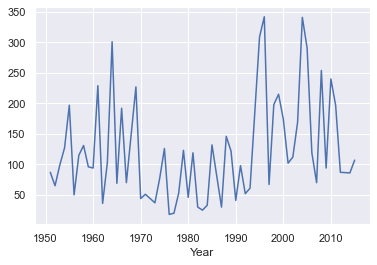

In [1162]:
data = pd.read_csv('Datasets/data_atl_merged2.csv',parse_dates=['Date'])
data = data[['ID', 'Name', 'Date','Year', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'sst', 'rhum',
       'wspd', 'slp', 'cldc']]
def category(mw):
    if mw>=137:
        return "Category 5"
    elif mw>=113:
        return "Category 4"
    elif mw>=96:
        return "Category 3"
    elif mw>=83:
        return "Category 2"
    elif mw>=64:
        return "Category 1"
    elif mw>=34:
        return "Tropical Storm"
    else:
        return "Tropical Depression"
cat_id = data.groupby('ID')['Maximum Wind'].max().apply(category)
data.loc[:,'Category']=data.ID.apply(lambda x:cat_id[x])
# data.groupby('Category')['ID'].count().plot.bar();
major_df = data[data.Category.apply(lambda x: 0 if x[-1]=='m' else int(x[-1]))>=3]
major_df.groupby('Year')['ID'].count().plot()

#Major Hurricanes by Year
# major_df = data[data.Category.apply(lambda x: 0 if x[-1]=='m' else int(x[-1]))>=3]

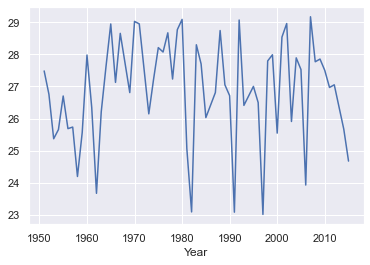

In [1192]:
X.sst.plot()

In [1169]:
count = major_df.groupby("Year")["ID"].count()

In [1216]:
X = pd.pivot_table(major_df, index="Year", values=["sst", "rhum", "wspd", "slp", "cldc"])

In [1217]:
countModel = sm.GLM(count, sm.add_constant(X), family=sm.families.NegativeBinomial())
countFit = countModel.fit()

In [1218]:
countFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     ID   No. Observations:                   60
Model:                            GLM   Df Residuals:                       55
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -347.79
Date:                Sun, 30 Aug 2020   Deviance:                       26.973
Time:                        03:58:23   Pearson chi2:                     27.4
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -188.0715    139.035     -1.353      0.176    -460.575      84.432
cldc           0.3847      0.555      0.693      0.489      -0.704       1.473
rhum           0.0171      0.067      0.255      0.798      -0.114       0.149
slp            0.1829      0.129      1.421      0.155      -0.069       0.435
sst            0.1321      0.123      1.071      0.284      -0.110       0.374
wspd           0.0171      0.067      0.255      0.798      -0.114       0.149
==============================================================================
"""

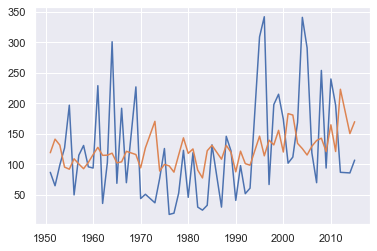

In [1220]:
plt.plot(count)
plt.plot(countFit.predict(sm.add_constant(X)))
plt.show() #que ruim